# Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,Dense

# Data Preparation

(a) Load and Prepare Data

In [14]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
ACC = pd.read_csv('46343_acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('46343_heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('46343_labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [15]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()
# หา start_timedelta, end_timedelta
print("Acc start    : "  + str(ACC_min_date) + " | Acc end    : " + str(ACC_max_date))
print("HeartR start : "  + str(HeartR_min_date) + " | HeartR end : " + str(HeartR_max_date))
print("SleepL start : "  + str(SleepL_min_date) + "             | SleepL end : " + str(SleepL_max_date))

Acc start    : -124489.16105 | Acc end    : 17643.046417
HeartR start : -556410.36066 | HeartR end : 16980.47229
SleepL start : 0             | SleepL end : 16980


In [16]:
# select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน)
# Ex
ACC_new = ACC[(ACC['timedelta'] > SleepL_min_date) & (ACC['timedelta'] < SleepL_max_date)]
HeartR_new = HeartR[(HeartR['timedelta'] > SleepL_min_date) & (HeartR['timedelta'] < SleepL_max_date)]
SleepL_new = SleepL[(SleepL['timedelta'] > SleepL_min_date) & (SleepL['timedelta'] < SleepL_max_date)]
ACC_new
# HeartR_new
# SleepL_new

,timedelta,accX,accY,accZ
98777,0.000721,-0.234650,0.905975,0.362747
98778,0.017162,-0.231232,0.893265,0.371613
98779,0.037183,-0.227814,0.915848,0.369049
98780,0.057108,-0.240524,0.919159,0.352890
98781,0.076929,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,16979.905934,-0.442413,-0.527573,0.723450
948797,16979.925889,-0.441925,-0.527573,0.721985
948798,16979.945849,-0.441437,-0.526108,0.721985
948799,16979.965927,-0.443405,-0.525116,0.723434


(b) Load and Prepare Data (ACC)

In [17]:
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
# Convert to datetime and round to second, 
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))

# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index() 
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()

# acc_X, acc_Y, acc_Z
ACC_new2 = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC_new2 = ACC_new2.loc[:,~ACC_new2.columns.duplicated()].copy()
ACC_new2

C:\Users\napat\AppData\Local\Temp\ipykernel_4480\2152281988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))


,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


(c) Load and Prepare Data (Heart rate)

In [18]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], unit= 's').round('1s'))

# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

C:\Users\napat\AppData\Local\Temp\ipykernel_4480\2085734111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], unit= 's').round('1s'))


,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


(d) Load and Prepare Data (Sleep Label)

In [19]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], unit= 's').round('1s'))

# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2.replace({-1:0},inplace=True)
SleepL_new2

C:\Users\napat\AppData\Local\Temp\ipykernel_4480\858305284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], unit= 's').round('1s'))


,sleep
timedelta,
0 days 00:00:30,0.0
0 days 00:00:31,0.0
0 days 00:00:32,0.0
0 days 00:00:33,0.0
0 days 00:00:34,0.0
...,...
0 days 04:42:26,0.0
0 days 04:42:27,0.0
0 days 04:42:28,0.0


(e) Merge Data and Standardized data

In [20]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC_new2, HeartR_new2, on = 'timedelta' )
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,NaN,NaN
1,0 days 00:00:01,-0.240757,0.873826,0.415446,NaN,NaN
2,0 days 00:00:02,-0.244620,0.883943,0.387026,NaN,NaN
3,0 days 00:00:03,-0.248036,0.902427,0.347812,NaN,NaN
4,0 days 00:00:04,-0.241778,0.912946,0.321502,NaN,NaN
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950,76.0,0.0
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410,76.0,0.0
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003,76.0,0.0
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265,76.0,0.0


In [21]:
# Fill NA
# Heart rate
# df.fillna() # using median()
hr_mean = df.heartrate.mean()
df.heartrate.fillna(hr_mean, inplace = True)
# Sleep Label
# df.fillna() # with 0
df.sleep.fillna(0, inplace = True)
# Drop column
df.drop(columns='timedelta',inplace=True)
df

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,80.886761,0.0
1,-0.240757,0.873826,0.415446,80.886761,0.0
2,-0.244620,0.883943,0.387026,80.886761,0.0
3,-0.248036,0.902427,0.347812,80.886761,0.0
4,-0.241778,0.912946,0.321502,80.886761,0.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.000000,0.0
16977,-0.441990,-0.525476,0.723410,76.000000,0.0
16978,-0.441581,-0.525116,0.724003,76.000000,0.0
16979,-0.442283,-0.525849,0.723265,76.000000,0.0


In [22]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
standard_scaler = StandardScaler()
df[feature_columns] = standard_scaler.fit_transform(df[feature_columns])

df_feature = df[feature_columns] # <= standardized data of df_feature
df_label = df[label_columns]
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.000000
1,-0.581456,2.995094,0.757746,0.000000
2,-0.591075,3.024668,0.722696,0.000000
3,-0.599581,3.078699,0.674335,0.000000
4,-0.583998,3.109450,0.641889,0.000000
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630391
16977,-1.082531,-1.095348,1.137542,-0.630391
16978,-1.081511,-1.094296,1.138273,-0.630391
16979,-1.083260,-1.096440,1.137363,-0.630391


(<AxesSubplot:>, <AxesSubplot:>)

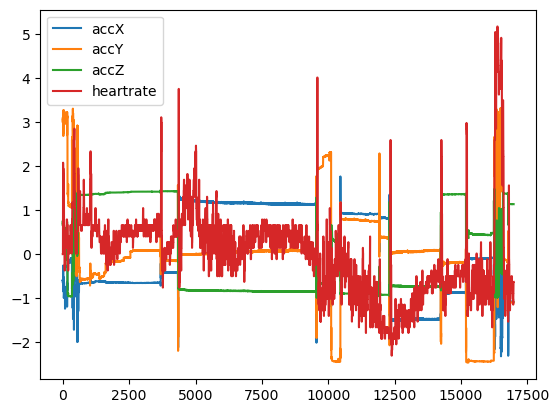

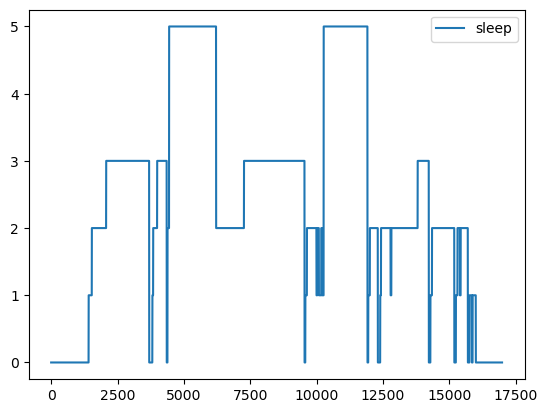

In [23]:
# Visualize signals
df_feature.plot(), df_label.plot()

In [24]:
# ------------ 1D to 3D feature-------------------------------
# set sliding window parameter
slidingW = 100
Stride_step = 5
n_features = 4
Nsets = 0
df_feature3D = np.array([],ndmin=2)
df_label_new = np.array([])

for t in range( 0 , len(df_feature), Stride_step ):
    F3d = np.array(df_feature[t : t + slidingW],ndmin=2)

    if len(F3d) < slidingW:
        break

    F3d.reshape(slidingW, n_features, 1)
    Nsets += 1
    df_feature3D = np.append(df_feature3D,F3d)
    Labels = stats.mode( df_label [t : t+slidingW])
    df_label_new = np.append(df_label_new, Labels[0])

df_feature3D = np.reshape(df_feature3D,(Nsets,slidingW,n_features))
df_feature3D = df_feature3D[..., np.newaxis]
df_feature3D.shape

C:\Users\napat\AppData\Local\Temp\ipykernel_4480\1149033774.py:19: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Labels = stats.mode( df_label [t : t+slidingW])


(3377, 100, 4, 1)

In [25]:
df_feature3D.shape

(3377, 100, 4, 1)

Train Test Split

In [26]:
# ------------ Train-Test-Split 2D features -------------------------------
x_train, x_test, y_train, y_test = train_test_split( df_feature, df_label)

# ------------ Train-Test-Split 3D features -------------------------------
x3D_train, x3D_test, y3D_train, y3D_test = train_test_split( df_feature3D , df_label_new)

# NN Model Train and Test

NN Model Train Test

In [27]:
# ------------ NN Architecture parameter -------------------------------
Hidden_Layer_param = (30, 30, 30)
mlp = MLPClassifier(hidden_layer_sizes = Hidden_Layer_param)
# View NN model parameters

In [28]:
# ------------ Training NN using 1D features -------------------------------
mlp.fit(x_train,y_train)
mlp_pred = mlp.predict(x_test)

c:\Users\napat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\napat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [30]:
# View Confusion Matrix and Classification Report
print(confusion_matrix(y_test,mlp_pred))
print(classification_report(y_test,mlp_pred))

[[ 644   33   36    9    1]
 [  35  108   69    1   10]
 [  46   38 1076   39   45]
 [   6    0   82 1109    1]
 [   0    1    7    0  850]]
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       723
         1.0       0.60      0.48      0.54       223
         2.0       0.85      0.86      0.86      1244
         3.0       0.96      0.93      0.94      1198
         5.0       0.94      0.99      0.96       858

    accuracy                           0.89      4246
   macro avg       0.84      0.83      0.84      4246
weighted avg       0.89      0.89      0.89      4246



# CNN Model Train and Test

CNN Model Train Test

In [31]:
# ------------ CNN Architecture parameter -------------------------------
# Nlayer (CNN, dense), Nnode, Activation
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
D_L1 = 512
D_out = 6
Activation = 'relu'
Ker_size = (3,3)
Pooling_size = (2,1)
Input_shape = (slidingW, n_features, 1)

In [32]:
# ------------ Create CNN Model -------------------------------
model = models.Sequential()
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Activation, input_shape=Input_shape,padding='same'))
model.add(MaxPooling2D(pool_size=Pooling_size))
model.add(Dropout(0.4))
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, activation= Activation, padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, activation= Activation,
padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(D_L1 , activation= Activation ))
model.add(Dense(D_out, activation='sigmoid'))
model.compile(optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 4, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 4, 16)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 4, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 4, 64)         9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 4, 64)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 4, 64)         0

CNN Model Train Test

In [33]:
# ------------ Create Optimizer -------------------------------
model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["acc"])

In [34]:
# ------ Train CNN using 3D feature--------------------------------------------
history = model.fit(x3D_train, y3D_train, epochs=50, batch_size=64,validation_data=(x3D_test, y3D_test))

Epoch 1/50


c:\Users\napat\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


40/40 [==============================] - 9s 188ms/step - loss: 1.1885 - acc: 0.4806 - val_loss: 0.8117 - val_acc: 0.6769
Epoch 2/50
40/40 [==============================] - 7s 179ms/step - loss: 0.6828 - acc: 0.7014 - val_loss: 0.5841 - val_acc: 0.7077
Epoch 3/50
40/40 [==============================] - 7s 177ms/step - loss: 0.5355 - acc: 0.7753 - val_loss: 0.5321 - val_acc: 0.7349
Epoch 4/50
40/40 [==============================] - 7s 168ms/step - loss: 0.4980 - acc: 0.7844 - val_loss: 0.4580 - val_acc: 0.8272
Epoch 5/50
40/40 [==============================] - 7s 165ms/step - loss: 0.4356 - acc: 0.8227 - val_loss: 0.4235 - val_acc: 0.8544
Epoch 6/50
40/40 [==============================] - 7s 166ms/step - loss: 0.4163 - acc: 0.8270 - val_loss: 0.3880 - val_acc: 0.8615
Epoch 7/50
40/40 [==============================] - 7s 164ms/step - loss: 0.3942 - acc: 0.8318 - val_loss: 0.3384 - val_acc: 0.8805
Epoch 8/50
40/40 [==============================] - 7s 166ms/step - loss: 0.3758 - acc:

In [35]:
# ------- Test CNN -------------------------------
CNN_pred = np.argmax(model.predict(x3D_test),axis=1)

27/27 [==============================] - 1s 24ms/step


Performnace of CNN Model

In [36]:
print(confusion_matrix(y3D_test,CNN_pred))
print(classification_report(y3D_test,CNN_pred))

[[129   0   9   0   0]
 [  2  19  13   0   0]
 [  1   0 241  19   5]
 [  1   0   1 236   0]
 [  0   0   0   0 169]]
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       138
         1.0       1.00      0.56      0.72        34
         2.0       0.91      0.91      0.91       266
         3.0       0.93      0.99      0.96       238
         5.0       0.97      1.00      0.99       169

    accuracy                           0.94       845
   macro avg       0.96      0.88      0.90       845
weighted avg       0.94      0.94      0.94       845



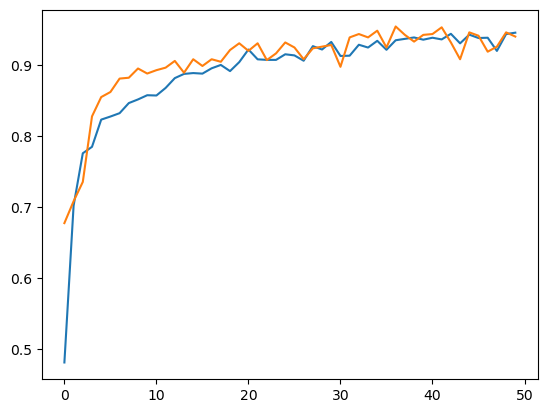

In [37]:
# ------ View History Graph -------------------------------------------
# View Accuracy Graph
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

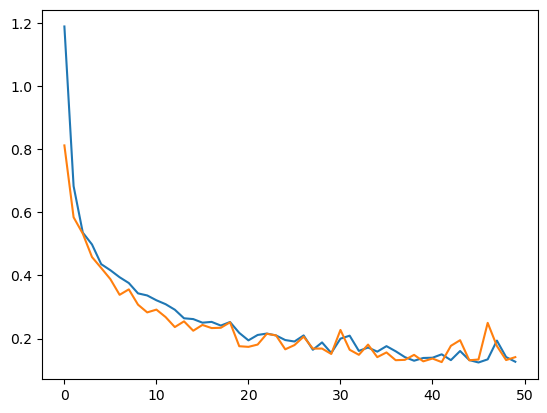

In [38]:
# View Loss Graph
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()